In [ ]:
#| default_exp training

In [ ]:
#| export

import torch, torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import gzip, pickle, matplotlib.pyplot as plt

In [ ]:
data_path = Path('../data/mnist.pkl.gz')
with gzip.open(data_path, 'r') as f:
    ((x_train, y_train), (x_test, y_test), _) = pickle.load(f, encoding='latin') 
x_train, y_train, x_test, y_test = map(torch.tensor, (x_train, y_train, x_test, y_test))
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

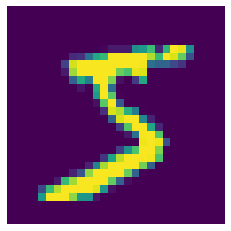

In [ ]:
img = x_train[0]
img = img.view(28, 28)
plt.imshow(img);
plt.axis('off');

```python
# simple 2 layer nn

```

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, n_h, n_o):
        super().__init__()
        self.layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_o)]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [ ]:
n_in = x_train.shape[1]
n_h = 50
n_o = 10

model = Model(n_in, n_h, n_o)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

```python
# cross entropy loss

```

In [ ]:
def log_softmax(x):
    return (x.exp()/x.exp().sum(-1, keepdim=True)).log()

In [ ]:
log_softmax(pred)

tensor([[-2.3105, -2.3146, -2.1153,  ..., -2.2368, -2.4307, -2.4524],
        [-2.3483, -2.3038, -2.2801,  ..., -2.2111, -2.5152, -2.3177],
        [-2.4311, -2.3641, -2.1093,  ..., -2.1862, -2.4990, -2.3351],
        ...,
        [-2.3080, -2.3101, -2.1713,  ..., -2.2585, -2.3865, -2.3988],
        [-2.3447, -2.2730, -2.1000,  ..., -2.3432, -2.4177, -2.3100],
        [-2.3322, -2.2556, -2.1236,  ..., -2.3390, -2.3710, -2.4355]],
       grad_fn=<LogBackward0>)

```python
# log product to sum trick

```

In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [ ]:
log_softmax(pred)

tensor([[-2.3105, -2.3146, -2.1153,  ..., -2.2368, -2.4307, -2.4524],
        [-2.3483, -2.3038, -2.2801,  ..., -2.2111, -2.5152, -2.3177],
        [-2.4311, -2.3641, -2.1093,  ..., -2.1862, -2.4990, -2.3351],
        ...,
        [-2.3080, -2.3101, -2.1713,  ..., -2.2585, -2.3865, -2.3988],
        [-2.3447, -2.2730, -2.1000,  ..., -2.3432, -2.4177, -2.3100],
        [-2.3322, -2.2556, -2.1236,  ..., -2.3390, -2.3710, -2.4355]],
       grad_fn=<SubBackward0>)

```python
# log sum exp trick
* normalize with the maximum value, so avoid exploding big activations.

```

In [ ]:
def logsumexp(x):
    m = x.max(-1)[-1]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [ ]:
def log_softmax(x):
    return x - logsumexp(x)[:,None]

In [ ]:
log_softmax(pred)

tensor([[-2.3105, -2.3146, -2.1153,  ..., -2.2368, -2.4307, -2.4524],
        [-2.3483, -2.3038, -2.2801,  ..., -2.2111, -2.5152, -2.3177],
        [-2.4311, -2.3641, -2.1093,  ..., -2.1862, -2.4990, -2.3351],
        ...,
        [-2.3080, -2.3101, -2.1713,  ..., -2.2585, -2.3865, -2.3988],
        [-2.3447, -2.2730, -2.1000,  ..., -2.3432, -2.4177, -2.3100],
        [-2.3322, -2.2556, -2.1236,  ..., -2.3390, -2.3710, -2.4355]],
       grad_fn=<SubBackward0>)

```python
# pytorch logsumexp function

```

In [ ]:
def log_softmax(x):
    return x - x.logsumexp(-1, keepdim=True)

In [ ]:
log_softmax(pred)

tensor([[-2.3105, -2.3146, -2.1153,  ..., -2.2368, -2.4307, -2.4524],
        [-2.3483, -2.3038, -2.2801,  ..., -2.2111, -2.5152, -2.3177],
        [-2.4311, -2.3641, -2.1093,  ..., -2.1862, -2.4990, -2.3351],
        ...,
        [-2.3080, -2.3101, -2.1713,  ..., -2.2585, -2.3865, -2.3988],
        [-2.3447, -2.2730, -2.1000,  ..., -2.3432, -2.4177, -2.3100],
        [-2.3322, -2.2556, -2.1236,  ..., -2.3390, -2.3710, -2.4355]],
       grad_fn=<SubBackward0>)

```python
# negative log likeliehood
* for one hot input vector, it simplifies to the following formula.

```

In [ ]:
def nll(inp, targ):
    return - inp[range(targ.shape[0]), targ].mean()

In [ ]:
sm_pred = log_softmax(pred)
loss = nll(sm_pred, y_train)
loss

tensor(2.3041, grad_fn=<NegBackward0>)

```python
# compare it with native pytorch implementation of nll.

```

In [ ]:
loss_pytorch = F.nll_loss(F.log_softmax(pred, -1), y_train)
loss_pytorch

tensor(2.3041, grad_fn=<NllLossBackward0>)

```python
# nll and softmax combined implementation.

```

In [ ]:
loss_pytorch = F.cross_entropy(pred, y_train)
loss_pytorch

tensor(2.3041, grad_fn=<NllLossBackward0>)

```python
# batch training.

```

```python
# accuracy.

```

In [ ]:
#|export

def accuracy(out, yb):
    return (out.argmax(1)==yb).float().mean()

In [ ]:
loss_func = F.cross_entropy

In [ ]:
bs = 50
xb = x_train[:bs]
yb = y_train[:bs]
preds = model(xb)
preds[0]

tensor([ 0.0027, -0.0013,  0.1980,  0.0608, -0.1618,  0.0345,  0.0952,  0.0764,
        -0.1174, -0.1391], grad_fn=<SelectBackward0>)

In [ ]:
loss_func(preds, yb)

tensor(2.3156, grad_fn=<NllLossBackward0>)

In [ ]:
accuracy(preds, yb)

tensor(0.0600)

In [ ]:
#|export

def report(loss, preds, yb):
    print(f"loss: {loss:.2f}, accuracy: {accuracy(preds, yb):.2f}")

In [ ]:
report(loss, preds, yb)

loss: 2.30, accuracy: 0.06


In [ ]:
n, m = x_train.shape
lr = 0.5
epochs = 3
xb,yb = x_train[:bs], y_train[:bs]
preds = model(xb)
loss = loss_func(preds, yb)
report(loss, preds, yb)

loss: 2.32, accuracy: 0.06


In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    report(loss, preds, yb)

loss: 0.08, accuracy: 0.98
loss: 0.07, accuracy: 0.98
loss: 0.03, accuracy: 1.00


```python

# parameters

```

In [ ]:
m1 = nn.Module()
m1.foo = nn.Linear(3, 4)
m1.boo = 'hey'
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [ ]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [ ]:
list(m1.parameters())

[Parameter containing:
 tensor([[-0.3483, -0.5673,  0.0903],
         [ 0.3015, -0.0302,  0.1472],
         [ 0.4863, -0.3693,  0.5638],
         [ 0.2693, -0.4972,  0.1921]], requires_grad=True),
 Parameter containing:
 tensor([-0.1241, -0.4176, -0.2312, -0.1247], requires_grad=True)]

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_in, n_h, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, n_h)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(n_h, n_out)
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [ ]:
model = MLP(n_in, n_h, 10)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
for name, l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
relu: ReLU()
l2: Linear(in_features=50, out_features=10, bias=True)


In [ ]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            xb,yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [ ]:
fit()

loss: 0.13, accuracy: 0.94
loss: 0.10, accuracy: 0.96
loss: 0.06, accuracy: 0.96


```python
# nn.Module behind the scene

```

In [ ]:
class MyModule:
    def __init__(self, n_in, n_h, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, n_h)
        self.l2 = nn.Linear(n_h, n_out)
        self.relu = nn.ReLU()
    
    def __setattr__(self, k, v):
        if not k.startswith('_'):
            self._modules[k] = v
        
        super().__setattr__(k, v)
    
    def __repr__(self):
        return f"{self._modules}"
    
    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()

In [ ]:
mdl = MyModule(n_in, n_h, n_o)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True), 'relu': ReLU()}

In [ ]:
for p in mdl.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


```python
# registering modules

```

In [ ]:
from functools import reduce

In [ ]:
layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_o)]

In [ ]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers):
            self.add_module(f"layer_{i}", l)
    
    def forward(self, x):
        return reduce(lambda val, layer: layer(val), self.layers, x)

In [ ]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
model(xb).shape

torch.Size([50, 10])

```python
# nn.ModuleList

```

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [ ]:
model = SequentialModel(layers)
model(xb).shape

torch.Size([50, 10])

```python
# nn.Sequential

```

In [ ]:
model = nn.Sequential(*layers)

In [ ]:
fit()

loss: 0.12, accuracy: 0.94
loss: 0.06, accuracy: 0.98
loss: 0.06, accuracy: 0.98


In [ ]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

```python
# optim

```

In [ ]:
class Optimizer:
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

In [ ]:
model = nn.Sequential(nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_o))

In [ ]:
opt = Optimizer(model.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.12, accuracy: 0.98
loss: 0.09, accuracy: 0.98
loss: 0.09, accuracy: 0.98


In [ ]:
from torch import optim

In [ ]:
def get_model():
    model = nn.Sequential(nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_o))
    opt = optim.SGD(model.parameters(), lr=lr)
    return opt, model

In [ ]:
opt, model = get_model()
loss_func(model(xb), yb)

tensor(2.3295, grad_fn=<NllLossBackward0>)

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(i+bs, n))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.14, accuracy: 0.92
loss: 0.11, accuracy: 0.96
loss: 0.05, accuracy: 1.00


```python
# dataset

```

In [ ]:
#|export

class Dataset:
    def __init__(self, x, y):
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [ ]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_test, y_test)

In [ ]:
opt, model = get_model()

In [ ]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i: min(i+bs, n)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

loss: 0.13, accuracy: 0.96
loss: 0.11, accuracy: 0.94
loss: 0.09, accuracy: 0.96


```python
# data loader

```

In [ ]:
class DataLoader:
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
    
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [ ]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [ ]:
xb, yb = next(iter(train_dl))
xb.shape

torch.Size([50, 784])

In [ ]:
opt, model = get_model()

In [ ]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [ ]:
fit()

loss: 0.12, accuracy: 0.98
loss: 0.11, accuracy: 0.96
loss: 0.11, accuracy: 0.96


```python

# random sampling

```

In [ ]:
import random

In [ ]:
class Sampler:
    def __init__(self, ds, shuffle=False):
        self.n, self.shuffle = len(ds), shuffle
    
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle:
            random.shuffle(res)
        return iter(res)

In [ ]:
from itertools import islice

In [ ]:
ss = Sampler(train_ds)

In [ ]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [ ]:
import fastcore.all as fc

In [ ]:
class BatchSampler:
    def __init__(self, sampler, bs, drop_last=False):
        fc.store_attr()
    
    def __iter__(self):
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [ ]:
batches = BatchSampler(ss, 5)
list(islice(iter(batches), 3))

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14]]

In [ ]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [ ]:
class DataLoader:
    def __init__(self, ds, batchs, collate_fn=collate):
        fc.store_attr()
    
    def __iter__(self):
        yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [ ]:
train_sampler = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_sampler = BatchSampler(Sampler(valid_ds, shuffle=True), bs)

In [ ]:
train_dl = DataLoader(train_ds, train_sampler)
valid_dl = DataLoader(valid_ds, valid_sampler)

In [ ]:
xb, yb = next(iter(valid_dl))
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

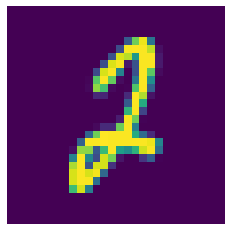

In [ ]:
plt.imshow(xb[0].view(28, 28));
plt.axis('off');

In [ ]:
opt, model = get_model()

In [ ]:
fit()

loss: 0.07, accuracy: 0.98
loss: 0.26, accuracy: 0.92
loss: 0.26, accuracy: 0.96


```python

# multiprocessing dataloader

```

In [ ]:
import torch.multiprocessing as mp

In [ ]:
class DataLoader:
    def __init__(self, ds, batchs, collate_fn=collate, num_workers=1):
        fc.store_attr()
    
    def __iter__(self):
        with mp.Pool(self.num_workers) as ex:
            yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [ ]:
train_dl = DataLoader(train_ds, batchs=train_sampler)

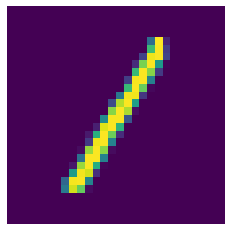

In [ ]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28, 28));
plt.axis('off');

```python
# pytorch dataloaders

```

In [ ]:
#| export

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [ ]:
t = RandomSampler(train_ds)

In [ ]:
next(iter(t))

2339

In [ ]:
t = BatchSampler(train_ds, batch_size=2, drop_last=False)

k  = next(iter(t))
print(len(k))
for ele in k:
    print(ele[0].shape, ele[1])

2
torch.Size([784]) tensor(5)
torch.Size([784]) tensor(0)


In [ ]:
t = BatchSampler(RandomSampler(train_ds), batch_size=2, drop_last=False)

k  = next(iter(t))
print(len(k))
for ele in k:
    print(ele)

2
10503
10784


In [ ]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(RandomSampler(valid_ds), bs, drop_last=False)

In [ ]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [ ]:
opt, model = get_model()
fit()

loss: 0.35, accuracy: 0.88
loss: 0.20, accuracy: 0.98
loss: 0.03, accuracy: 0.98


In [ ]:
train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=2, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [ ]:
opt, model = get_model()
fit()

loss: 0.13, accuracy: 0.96
loss: 0.04, accuracy: 1.00
loss: 0.03, accuracy: 0.98


```python

# validation

```

In [ ]:
#|export

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        model.eval()
        with torch.no_grad():
            total_loss, total_acc, count = 0., 0., 0
            for xb, yb in valid_dl:
                preds = model(xb)
                n = len(xb)
                count += n
                total_loss += loss_func(preds, yb).item()*n
                total_acc += accuracy(preds, yb).item()*n
        print(epoch, total_loss/count, total_acc/count)
    
    return total_loss/count, total_acc/count           

In [ ]:
#|export

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (
        DataLoader(train_ds, bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, bs*2, shuffle=False, **kwargs)
    )

In [ ]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
opt, model = get_model()

In [ ]:
%time loss, acc =  fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.1471907559596002 0.9581000053882599
1 0.12014570286497474 0.9649000048637391
2 0.13957091552205383 0.9609000051021576
3 0.11519455040339381 0.9696000063419342
4 0.10710318600060419 0.9718000078201294
CPU times: user 14.9 s, sys: 15.9 s, total: 30.8 s
Wall time: 4.43 s


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export();